In [ ]:
# Install Spark (Colab)
!pip install pyspark

# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import os

# Start Spark session
spark = SparkSession.builder \
    .appName("MedicareBillingOutliers") \
    .getOrCreate()

print("Spark session initialized.")
print("Current working directory:", os.getcwd())


Spark session initialized.
Current working directory: /content


In [ ]:
# --- STEP 2: Upload the CSV file into Colab ---

from google.colab import files

print("Please choose your Medicare CSV file (e.g., MUP_PHY_R25_P05_V20_D23_Prov.csv)")
uploaded = files.upload()  # This opens a file picker

# Get the first uploaded file name
csv_filename = list(uploaded.keys())[0]
print("Uploaded file:", csv_filename)

# Define file_path for Spark using the uploaded file
file_path = f"/content/{csv_filename}"
print("file_path set to:", file_path)



Please choose your Medicare CSV file (e.g., MUP_PHY_R25_P05_V20_D23_Prov.csv)


Saving MUP_PHY_R25_P05_V20_D23_Prov.csv to MUP_PHY_R25_P05_V20_D23_Prov.csv
Uploaded file: MUP_PHY_R25_P05_V20_D23_Prov.csv
file_path set to: /content/MUP_PHY_R25_P05_V20_D23_Prov.csv


In [ ]:
# --- STEP 3: Load the dataset using Spark ---

print("Reading CSV with Spark...")
df = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True
)

print("Done loading!")
print("Total rows:", df.count())
print("Total columns:", len(df.columns))
df.printSchema()


Reading CSV with Spark...
Done loading!
Total rows: 1259343
Total columns: 81
root
 |-- Rndrng_NPI: integer (nullable = true)
 |-- Rndrng_Prvdr_Last_Org_Name: string (nullable = true)
 |-- Rndrng_Prvdr_First_Name: string (nullable = true)
 |-- Rndrng_Prvdr_MI: string (nullable = true)
 |-- Rndrng_Prvdr_Crdntls: string (nullable = true)
 |-- Rndrng_Prvdr_Ent_Cd: string (nullable = true)
 |-- Rndrng_Prvdr_St1: string (nullable = true)
 |-- Rndrng_Prvdr_St2: string (nullable = true)
 |-- Rndrng_Prvdr_City: string (nullable = true)
 |-- Rndrng_Prvdr_State_Abrvtn: string (nullable = true)
 |-- Rndrng_Prvdr_State_FIPS: string (nullable = true)
 |-- Rndrng_Prvdr_Zip5: string (nullable = true)
 |-- Rndrng_Prvdr_RUCA: double (nullable = true)
 |-- Rndrng_Prvdr_RUCA_Desc: string (nullable = true)
 |-- Rndrng_Prvdr_Cntry: string (nullable = true)
 |-- Rndrng_Prvdr_Type: string (nullable = true)
 |-- Rndrng_Prvdr_Mdcr_Prtcptg_Ind: string (nullable = true)
 |-- Tot_HCPCS_Cds: integer (nullable = tr

In [ ]:
# SECTION 2 — SELECT RELEVANT VARIABLES
# -----------------------------------------------------------------------------------
# Select the variables required for billing ratio computation and anomaly detection.
# The CMS dataset contains over 100 fields, so selecting only essential columns
# improves performance and memory efficiency.
# -----------------------------------------------------------------------------------

from pyspark.sql.functions import col, mean, max, expr, avg, stddev, when

cols_needed = [
    "Rndrng_NPI",
    "Rndrng_Prvdr_Type",
    "Rndrng_Prvdr_State_Abrvtn",
    "Tot_Sbmtd_Chrg",
    "Tot_Mdcr_Alowd_Amt",
    "Tot_Mdcr_Pymt_Amt",
    "Tot_Srvcs",
    "Bene_Avg_Risk_Scre"
]

df2 = df.select(cols_needed)

# Preview the selected subset.
df2.show(5)

# SECTION 3 — DATA CLEANING AND BILLING RATIO CREATION
# -----------------------------------------------------------------------------------
# Clean the dataset:
# 1. Remove rows where submitted charges or allowed amounts are missing.
# 2. Remove records with allowed amount equal to zero to avoid division errors.
# -----------------------------------------------------------------------------------

clean = df2.dropna(subset=["Tot_Sbmtd_Chrg", "Tot_Mdcr_Alowd_Amt"]) \
           .filter(col("Tot_Mdcr_Alowd_Amt") > 0)

# -----------------------------------------------------------------------------------
# Create billing_ratio:
# This metric is central to our analysis because it captures how much a provider bills
# relative to what Medicare considers allowable.
# -----------------------------------------------------------------------------------

clean = clean.withColumn(
    "billing_ratio",
    col("Tot_Sbmtd_Chrg") / col("Tot_Mdcr_Alowd_Amt")
)

# Summary statistics help verify distribution and detect potential anomalies.
clean.select("billing_ratio").describe().show()


+----------+--------------------+-------------------------+--------------+------------------+-----------------+---------+------------------+
|Rndrng_NPI|   Rndrng_Prvdr_Type|Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|Tot_Mdcr_Pymt_Amt|Tot_Srvcs|Bene_Avg_Risk_Scre|
+----------+--------------------+-------------------------+--------------+------------------+-----------------+---------+------------------+
|1003000126|         Hospitalist|                       MD|     173087.77|          78590.79|         62198.36|    814.0|            2.7545|
|1003000134|           Pathology|                       IL|      726858.0|         171256.75|        127984.95|   4839.0|            1.1423|
|1003000142|      Anesthesiology|                       OH|      451425.0|         155879.22|        118122.12|   1455.0|            1.6448|
|1003000423|Obstetrics & Gyne...|                       OH|       13785.0|           6388.39|          5230.52|    119.0|             0.737|
|1003000480| 

Converting sample of billing_ratio to Pandas...


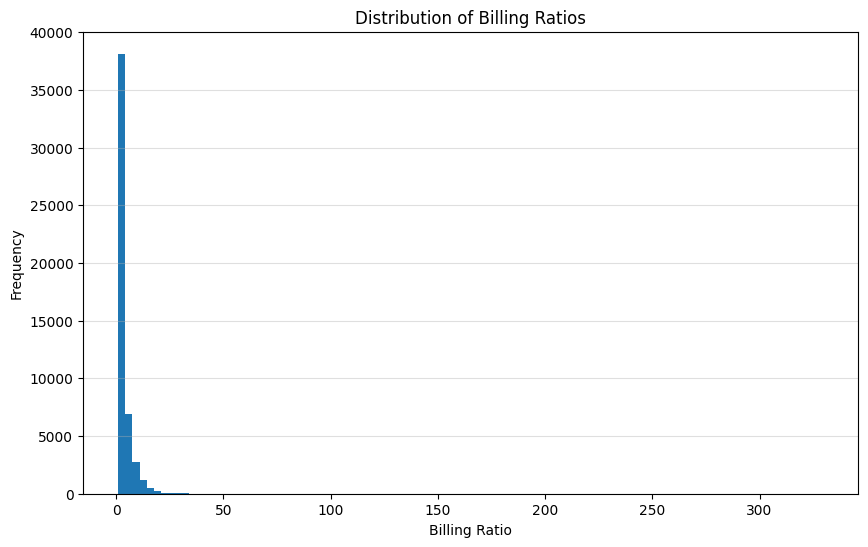

In [ ]:
# SECTION 4 & 5 — SUMMARY STATS + HISTOGRAM VISUALIZATION
# -------------------------------------------------------------------------
# Convert the billing_ratio column to a Pandas DataFrame for plotting.
# Spark → Pandas is safe because we only convert ONE column, not the full dataset.
# -------------------------------------------------------------------------

print("Converting sample of billing_ratio to Pandas...")
sample_list = clean.select("billing_ratio").rdd.map(lambda r: r[0]).take(50000)
sample_pd = pd.DataFrame(sample_list, columns=["billing_ratio"])

# -------------------------------------------------------------------------
# Plot Histogram
# -------------------------------------------------------------------------
plt.figure(figsize=(10,6))
plt.hist(sample_pd["billing_ratio"], bins=100)
plt.title("Distribution of Billing Ratios")
plt.xlabel("Billing Ratio")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.4)
plt.show()


In [ ]:
# SECTION 6 — IQR OUTLIER DETECTION
# -------------------------------------------------------------------------
# Using Interquartile Range (IQR) to detect extreme billing ratios.
# Providers whose billing_ratio is far above Q3 are potential anomalies.
# -------------------------------------------------------------------------

# Compute Q1, Q3
q1, q3 = clean.approxQuantile("billing_ratio", [0.25, 0.75], 0.0)
iqr = q3 - q1

# Define outlier thresholds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("IQR:", iqr)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Filter outliers based on IQR
iqr_outliers = clean.filter(
    (col("billing_ratio") < lower_bound) |
    (col("billing_ratio") > upper_bound)
)

print("Number of IQR outliers:", iqr_outliers.count())
iqr_outliers.select("Rndrng_NPI", "billing_ratio").show(10, truncate=False)


IQR: 2.170639895548512
Lower Bound: -1.3115029826069722
Upper Bound: 7.371056599587076
Number of IQR outliers: 129095
+----------+------------------+
|Rndrng_NPI|billing_ratio     |
+----------+------------------+
|1003001041|30.83909455544429 |
|1003002205|14.347582786194618|
|1003002809|15.27806081411999 |
|1003003963|8.26494603284725  |
|1003006115|8.107045208234224 |
|1003006727|8.719843773057196 |
|1003007360|10.078408705790222|
|1003007469|12.940374777084857|
|1003007964|10.30618006310206 |
|1003008269|10.360377080623783|
+----------+------------------+
only showing top 10 rows



In [ ]:
# SECTION 7 — Z-SCORE OUTLIER DETECTION
# -----------------------------------------------------------------------------
# Z-score helps identify providers whose billing_ratio is many standard deviations
# away from the mean — another classic anomaly detection method.
# -----------------------------------------------------------------------------

# Compute mean and stddev
stats = clean.select(
    avg(col("billing_ratio")).alias("mean"),
    stddev(col("billing_ratio")).alias("stddev")
).collect()[0]

mean_val = stats["mean"]
std_val = stats["stddev"]

print("Mean Billing Ratio:", mean_val)
print("Stddev Billing Ratio:", std_val)

# Add z_score column
clean_z = clean.withColumn(
    "z_score",
    (col("billing_ratio") - mean_val) / std_val
)

# Define threshold for outliers (3 standard deviations)
z_outliers = clean_z.filter((col("z_score") > 3) | (col("z_score") < -3))

print("Number of Z-Score outliers:", z_outliers.count())
z_outliers.select("Rndrng_NPI", "billing_ratio", "z_score").show(10, truncate=False)


Mean Billing Ratio: 3.8473223933731266
Stddev Billing Ratio: 4.13518558088684
Number of Z-Score outliers: 18607
+----------+------------------+------------------+
|Rndrng_NPI|billing_ratio     |z_score           |
+----------+------------------+------------------+
|1003001041|30.83909455544429 |6.527342397117388 |
|1003011966|16.39085452975193 |3.0333661914367323|
|1003012444|19.84685105245094 |3.8691198607938957|
|1003017518|30.738370979456615|6.502984705299824 |
|1003023359|20.386246880569725|3.999560397879321 |
|1003026212|19.139135805135414|3.697975124125572 |
|1003027269|18.672412527892988|3.58510878037557  |
|1003029141|17.69237161907319 |3.3481083145803643|
|1003029323|32.406111334833746|6.906289544406818 |
|1003037508|28.023021062464217|5.846339468011572 |
+----------+------------------+------------------+
only showing top 10 rows



In [ ]:
# SECTION 10 — DETERMINE NUMERIC COLUMNS FOR MODELING
# ------------------------------------------------------------------------------
# This prepares the dataset for machine learning by:
# 1. Identifying numeric columns
# 2. Ensuring correct schema
# 3. Loading a small sample to inspect data integrity
# ------------------------------------------------------------------------------

from pyspark.sql.types import NumericType

# Identify numeric columns in the full dataset
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

print("Numeric columns detected:", numeric_cols)
print("Total numeric columns:", len(numeric_cols))

# ----------------------------------------------------------------------
# Load a SAMPLE of the dataset for inspection (5% sample)
# ----------------------------------------------------------------------
sample = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"',
    samplingRatio=0.05
)

print("Sample row count:", sample.count())
sample.show(5)

# ----------------------------------------------------------------------
# Re-load dataset with proper schema using inferSchema
# ----------------------------------------------------------------------
df_full = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)

print("Full dataset loaded with schema correction.")
df_full.printSchema()

# Filter to only numeric columns
df_numeric = df_full.select(numeric_cols)

print("Numeric-only dataframe rows:", df_numeric.count())
print("Numeric-only dataframe columns:", len(df_numeric.columns))
df_numeric.show(5)


Numeric columns detected: ['Rndrng_NPI', 'Rndrng_Prvdr_RUCA', 'Tot_HCPCS_Cds', 'Tot_Benes', 'Tot_Srvcs', 'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Alowd_Amt', 'Tot_Mdcr_Pymt_Amt', 'Tot_Mdcr_Stdzd_Amt', 'Drug_Tot_HCPCS_Cds', 'Drug_Tot_Benes', 'Drug_Tot_Srvcs', 'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Alowd_Amt', 'Drug_Mdcr_Pymt_Amt', 'Drug_Mdcr_Stdzd_Amt', 'Med_Tot_HCPCS_Cds', 'Med_Tot_Benes', 'Med_Tot_Srvcs', 'Med_Sbmtd_Chrg', 'Med_Mdcr_Alowd_Amt', 'Med_Mdcr_Pymt_Amt', 'Med_Mdcr_Stdzd_Amt', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt', 'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt', 'Bene_Male_Cnt', 'Bene_Race_Wht_Cnt', 'Bene_Race_Black_Cnt', 'Bene_Race_API_Cnt', 'Bene_Race_Hspnc_Cnt', 'Bene_Race_NatInd_Cnt', 'Bene_Race_Othr_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt', 'Bene_CC_BH_ADHD_OthCD_V1_Pct', 'Bene_CC_BH_Alcohol_Drug_V1_Pct', 'Bene_CC_BH_Tobacco_V1_Pct', 'Bene_CC_BH_Alz_NonAlzdem_V2_Pct', 'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Bipolar_V1_Pct', 'Bene_CC_BH_Mood_V2_Pct', 'Bene_CC

In [ ]:
# NEW SECTION 11 — CLEAN NUMERIC DATA + KMEANS + GMM CLUSTERING
# -------------------------------------------------------------------
# Fix: Spark was failing in VectorAssembler because some numeric columns
# contain null / NaN values. We:
#   1) Clean all numeric columns (replace null/NaN with 0)
#   2) Assemble features
#   3) Scale features
#   4) Run KMeans and GMM
# -------------------------------------------------------------------

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.sql.functions import col, when, isnan
from pyspark.sql.types import NumericType

# 1) Reconfirm numeric columns (from df_full)
numeric_cols = [field.name for field in df_full.schema.fields if isinstance(field.dataType, NumericType)]
print("Numeric columns used for clustering:", numeric_cols)
print("Total numeric columns:", len(numeric_cols))

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found for clustering.")

# 2) Select numeric-only dataframe
df_numeric = df_full.select(numeric_cols)

# 3) CLEAN numeric columns: replace null / NaN with 0
df_numeric_clean = df_numeric.select([
    when(col(c).isNull() | isnan(col(c)), 0).otherwise(col(c)).alias(c)
    for c in numeric_cols
])

print("Cleaned numeric dataframe:")
df_numeric_clean.show(5)

# -----------------------------
# 4) Assemble features
# -----------------------------
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features"
)

df_vec = assembler.transform(df_numeric_clean).select("features")

print("VectorAssembler completed. Example row:")
df_vec.show(5, truncate=False)

# -----------------------------
# 5) Scale features
# -----------------------------
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec).select("scaled_features")

print("StandardScaler completed.")
df_scaled.show(5, truncate=False)

# -----------------------------
# 6) KMeans clustering
# -----------------------------
kmeans = KMeans(
    featuresCol="scaled_features",
    predictionCol="kmeans_cluster",
    k=5
)

kmeans_model = kmeans.fit(df_scaled)
df_kmeans = kmeans_model.transform(df_scaled)

print("KMeans clustering completed.")
df_kmeans.show(10, truncate=False)



Numeric columns used for clustering: ['Rndrng_NPI', 'Rndrng_Prvdr_RUCA', 'Tot_HCPCS_Cds', 'Tot_Benes', 'Tot_Srvcs', 'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Alowd_Amt', 'Tot_Mdcr_Pymt_Amt', 'Tot_Mdcr_Stdzd_Amt', 'Drug_Tot_HCPCS_Cds', 'Drug_Tot_Benes', 'Drug_Tot_Srvcs', 'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Alowd_Amt', 'Drug_Mdcr_Pymt_Amt', 'Drug_Mdcr_Stdzd_Amt', 'Med_Tot_HCPCS_Cds', 'Med_Tot_Benes', 'Med_Tot_Srvcs', 'Med_Sbmtd_Chrg', 'Med_Mdcr_Alowd_Amt', 'Med_Mdcr_Pymt_Amt', 'Med_Mdcr_Stdzd_Amt', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt', 'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt', 'Bene_Male_Cnt', 'Bene_Race_Wht_Cnt', 'Bene_Race_Black_Cnt', 'Bene_Race_API_Cnt', 'Bene_Race_Hspnc_Cnt', 'Bene_Race_NatInd_Cnt', 'Bene_Race_Othr_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt', 'Bene_CC_BH_ADHD_OthCD_V1_Pct', 'Bene_CC_BH_Alcohol_Drug_V1_Pct', 'Bene_CC_BH_Tobacco_V1_Pct', 'Bene_CC_BH_Alz_NonAlzdem_V2_Pct', 'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Bipolar_V1_Pct', 'Bene_CC_BH_Mood_V2_Pct

In [ ]:
from pyspark.ml.clustering import GaussianMixture

# Use a 5% random sample of the scaled data
df_scaled_sample = df_scaled.sample(False, 0.05, seed=42)

print("Sampled rows for GMM:", df_scaled_sample.count())

gmm = GaussianMixture(
    featuresCol="scaled_features",
    predictionCol="gmm_cluster",
    probabilityCol="gmm_probability",
    k=5
)

gmm_model = gmm.fit(df_scaled_sample)
df_gmm = gmm_model.transform(df_scaled_sample)

print("Gaussian Mixture Model (sample) completed.")
df_gmm.select("scaled_features", "gmm_cluster", "gmm_probability").show(10, truncate=False)


Sampled rows for GMM: 63162
Gaussian Mixture Model (sample) completed.
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# FIX: Add billing_ratio to df_full before joining

df_full = df_full.withColumn(
    "billing_ratio",
    col("Tot_Sbmtd_Chrg") / col("Tot_Mdcr_Alowd_Amt")
)


In [ ]:
# STEP A — JOIN CLUSTERS WITH ORIGINAL DATA
# ---------------------------------------------------------------
# We join:
#   df_full  (full dataset with all numeric/prov columns)
#   df_kmeans (has only scaled_features + kmeans_cluster)
#   df_gmm    (sampled GMM results)
#
# We join using row indices (monotonically increasing ID)
# ---------------------------------------------------------------

from pyspark.sql.functions import monotonically_increasing_id

# Add row_id to each dataframe
df_full_with_id = df_full.withColumn("row_id", monotonically_increasing_id())
df_kmeans_with_id = df_kmeans.withColumn("row_id", monotonically_increasing_id())
df_gmm_sample_with_id = df_gmm.withColumn("row_id", monotonically_increasing_id())

# Join full → KMeans
joined_kmeans = df_full_with_id.join(df_kmeans_with_id, on="row_id", how="left")

# Join KMeans → GMM (sampled)
final_df = joined_kmeans.join(df_gmm_sample_with_id, on="row_id", how="left")

print("Final joined dataframe preview:")
final_df.select(
    "Rndrng_NPI",
    "Rndrng_Prvdr_Type",
    "Rndrng_Prvdr_State_Abrvtn",
    "Tot_Sbmtd_Chrg",
    "Tot_Mdcr_Alowd_Amt",
    "billing_ratio",
    "kmeans_cluster",
    "gmm_cluster",
    "gmm_probability"
).show(20, truncate=False)


Final joined dataframe preview:
+----------+---------------------------------------------+-------------------------+--------------+------------------+------------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------+
|Rndrng_NPI|Rndrng_Prvdr_Type                            |Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|billing_ratio     |kmeans_cluster|gmm_cluster|gmm_probability                                                                                                 |
+----------+---------------------------------------------+-------------------------+--------------+------------------+------------------+--------------+-----------+----------------------------------------------------------------------------------------------------------------+
|1003000126|Hospitalist                                  |MD                       |173087.77     |78590.79          |2.20239254497887

In [ ]:
from pyspark.sql.functions import col

# STEP B — Top anomalies based on GMM probability
# We only keep rows where GMM ran (non-null probability),
# then sort by lowest probability = most unusual behavior.

anomalies = (
    final_df
    .filter(col("gmm_probability").isNotNull())
    .orderBy(col("gmm_probability").asc())
    .select(
        "Rndrng_NPI",
        "Rndrng_Prvdr_Type",
        "Rndrng_Prvdr_State_Abrvtn",
        "Tot_Sbmtd_Chrg",
        "Tot_Mdcr_Alowd_Amt",
        "billing_ratio",
        "kmeans_cluster",
        "gmm_cluster",
        "gmm_probability"
    )
    .limit(20)
)

print("Top 20 most anomalous providers (lowest GMM probability):")
anomalies.show(20, truncate=False)


Top 20 most anomalous providers (lowest GMM probability):
+----------+---------------------------------------------+-------------------------+--------------+------------------+------------------+--------------+-----------+-------------------------------------------------------------------------------------------------+
|Rndrng_NPI|Rndrng_Prvdr_Type                            |Rndrng_Prvdr_State_Abrvtn|Tot_Sbmtd_Chrg|Tot_Mdcr_Alowd_Amt|billing_ratio     |kmeans_cluster|gmm_cluster|gmm_probability                                                                                  |
+----------+---------------------------------------------+-------------------------+--------------+------------------+------------------+--------------+-----------+-------------------------------------------------------------------------------------------------+
|1023216256|Diagnostic Radiology                         |MN                       |574343.39     |82109.62          |6.994836780391871 |3             |2

In [ ]:
# Export the top 20 anomalies to CSV
anomalies.toPandas().to_csv("top20_anomalies.csv", index=False)
from google.colab import files
files.download("top20_anomalies.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

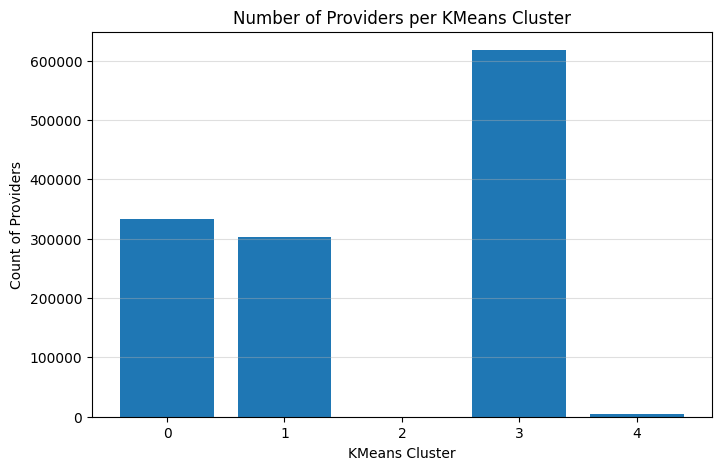

,kmeans_cluster,count
0,0,333753
1,1,303209
2,2,52
3,3,617761
4,4,4568


In [ ]:
# VIS 2 — KMeans Cluster Sizes

cluster_counts = (
    final_df
    .groupBy("kmeans_cluster")
    .count()
    .orderBy("kmeans_cluster")
    .toPandas()
)

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts["kmeans_cluster"], cluster_counts["count"])
plt.title("Number of Providers per KMeans Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("Count of Providers")
plt.grid(axis="y", alpha=0.4)
plt.show()

cluster_counts


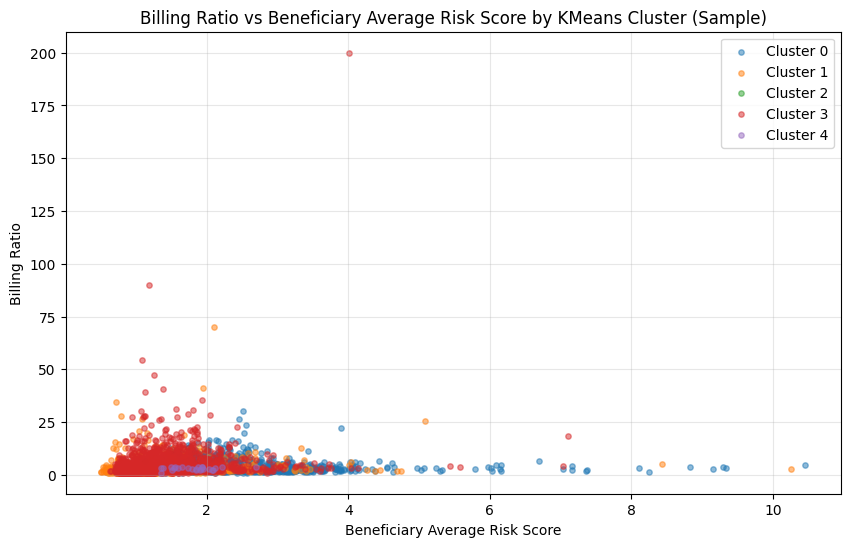

In [ ]:
# VIS 3 — Scatter: Billing Ratio vs Beneficiary Risk Score by Cluster (Sample)

from pyspark.sql.functions import rand

# Select needed columns and sample
scatter_sample = (
    final_df
    .select(
        "billing_ratio",
        "Bene_Avg_Risk_Scre",
        "kmeans_cluster"
    )
    .dropna()
    .orderBy(rand())
    .limit(5000)
)

scatter_pd = scatter_sample.toPandas()

plt.figure(figsize=(10, 6))

# Simple scatter by cluster
for cluster_id in sorted(scatter_pd["kmeans_cluster"].unique()):
    subset = scatter_pd[scatter_pd["kmeans_cluster"] == cluster_id]
    plt.scatter(
        subset["Bene_Avg_Risk_Scre"],
        subset["billing_ratio"],
        label=f"Cluster {cluster_id}",
        alpha=0.5,
        s=15
    )

plt.title("Billing Ratio vs Beneficiary Average Risk Score by KMeans Cluster (Sample)")
plt.xlabel("Beneficiary Average Risk Score")
plt.ylabel("Billing Ratio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


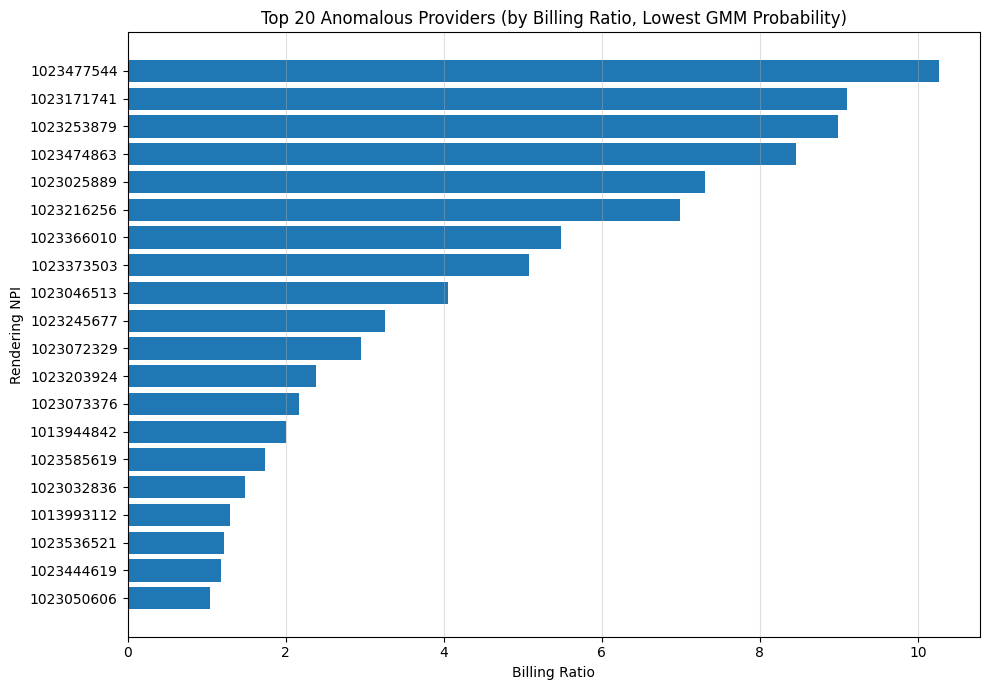

,Rndrng_NPI,Rndrng_Prvdr_Type,Rndrng_Prvdr_State_Abrvtn,billing_ratio,gmm_probability
12,1023050606,Mass Immunizer Roster Biller,AZ,1.046160,"[4.280385502814704e-22, 4.279113385053995e-22,..."
4,1023444619,Nurse Practitioner,OK,1.188463,"[3.968973976803877e-22, 3.9686228150027843e-22..."
17,1023536521,Licensed Clinical Social Worker,NM,1.214601,"[4.388946821410289e-22, 4.388800356988523e-22,..."
14,1013993112,Optometry,IL,1.300262,"[4.345472474759412e-22, 4.345150191241321e-22,..."
7,1023032836,"Psychologist, Clinical",OR,1.490762,"[4.118785979519257e-22, 4.1186291016547965e-22..."
3,1023585619,Nurse Practitioner,VA,1.735863,"[3.9319536824776195e-22, 3.9315767924791557e-2..."
13,1013944842,Chiropractic,AZ,2.000668,"[4.284622032061666e-22, 4.284080202198608e-22,..."
1,1023073376,Rheumatology,NC,2.166806,"[3.9004378054194223e-22, 3.9001525021642456e-2..."
8,1023203924,Orthopedic Surgery,CA,2.378461,"[4.1359469664803424e-22, 4.1358198846164724e-2..."
15,1023072329,Internal Medicine,PA,2.951850,"[4.382765615685525e-22, 4.3820119668016955e-22..."


In [ ]:
# VIS 4 — Top 20 Anomalous Providers by Billing Ratio (from GMM anomalies)

anom_pd = anomalies.toPandas()

# Sort so the biggest billing ratios show at top of plot
anom_pd = anom_pd.sort_values("billing_ratio", ascending=True)

plt.figure(figsize=(10, 7))
plt.barh(anom_pd["Rndrng_NPI"].astype(str), anom_pd["billing_ratio"])
plt.title("Top 20 Anomalous Providers (by Billing Ratio, Lowest GMM Probability)")
plt.xlabel("Billing Ratio")
plt.ylabel("Rendering NPI")
plt.grid(axis="x", alpha=0.4)
plt.tight_layout()
plt.show()

anom_pd[["Rndrng_NPI", "Rndrng_Prvdr_Type", "Rndrng_Prvdr_State_Abrvtn", "billing_ratio", "gmm_probability"]]


In [ ]:
!ls /content


MUP_PHY_R25_P05_V20_D23_Prov.csv  sample_data  top20_anomalies.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/BigData_Project.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/BigData_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 712320 bytes to /content/drive/MyDrive/Colab Notebooks/BigData_Project.html


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Colab Notebooks/BigData_Project.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>